# SEIRS model with Cost Analysis

# Imports
Before running anything, import these libraries:

In [1]:
import pandas as pd
from seirsplus.models import *
import networkx
import pickle
import matplotlib.pyplot as plt
import random
import math

## 0. File Setup
Start here if `worker_data_final.pickle` is not in the file system. If you cloned the repo, you don't need to run this code.

In [ ]:
# build pandas dataframe from excel file
filePath = 'Work_Context.xlsx'
worker_data = pd.read_excel(filePath)
# Save file so it does not have to be recompiled
with open('pickles/worker_data.pickle', 'wb') as file:
    pickle.dump(worker_data, file)

In [ ]:
filePath = 'national_M2019_dl.xlsx'
occupation_data = pd.read_excel(filePath)
# Save file so it does not have to be recompiled
with open('pickles/occupation_data.pickle', 'wb') as file:
    pickle.dump(occupation_data, file)

Start here if `worker_data_final.pickle` is not in the file system

In [ ]:
with open('pickles/occupation_data.pickle', 'rb') as file:
    occupation_data = pickle.load(file)
with open('pickles/worker_data.pickle', 'rb') as file:
    worker_data = pickle.load(file)

## 1. Parse Data (Dept. of Labor)

The Depertment of Labor data contains a whole swath of contextual information about each occupation within its database. The only features were are interested in are the metrics on a job's `Exposed to Disease or Infections` and `Physical Proximity` measures. These can be found in the `worker_data` object in this notebook and here (https://www.onetcenter.org/database.html#individual-files). `Employment` and `Annual Income` can be found in the `occupation_data` object and this website (https://www.bls.gov/oes/current/oes_nat.htm#11-0000).

In [ ]:
""" WORKER_DATA Filter rows based on relevant characteristics """
relevant_elements = ["Exposed to Disease or Infections", "Physical Proximity"]
characteristics = worker_data['Element Name']

worker_data_filtered = worker_data.loc[
    (worker_data['Element Name'].isin(relevant_elements)) # filter on characteristics
    & (worker_data['Scale ID'] == 'CX')] # filter on score (out of 5)

worker_data_filtered = worker_data_filtered.filter(items=['O*NET-SOC Code','Title', 'Element Name', 'Data Value'])
worker_data_filtered["O*NET-SOC Code"] = worker_data_filtered["O*NET-SOC Code"].apply(lambda x: x.split(".")[0])

In [ ]:
# Build crosslisting between worker_data and occupation_data based on occ_code
occupation_list = worker_data_filtered['O*NET-SOC Code']
# Strip CC in AAA-BBBB.CC format of the job identifier in the worker_data Dataframe

In [ ]:
""" OCCUPATION DATA Filter rows based on relevant characteristics """
# Get population and income data for occupations
occupation_data_filtered = occupation_data.loc[
    (occupation_data['occ_code'].isin(occupation_list))] # filter on characteristics

occupation_data_filtered = occupation_data_filtered.filter(items=['occ_code','occ_title','tot_emp','a_mean'])
occupation_data_filtered = occupation_data_filtered.rename(columns={'occ_title':'Title', 'tot_emp':'Employment','a_mean':'Annual Income', 'occ_code':'O*NET-SOC Code'})

# general_population = occupation_data_filtered.iloc[0][2] # first entry of the Employment column

In [ ]:
occupation_data_filtered.head()

In [ ]:
worker_data_filtered.head()

In [ ]:
""" Reformat Dataframe to include the below features """
# Title, Context Score 1, Context Score 2
dataframes = []
for element in relevant_elements:
    df = worker_data_filtered.copy()
    df = df[characteristics == element]
    df = df.drop(columns=['Element Name'])
    df = df.rename(columns={'Data Value': element})
    dataframes.append(df)

from functools import reduce
worker_data_final = reduce(lambda df1,df2: pd.merge(df1,df2,on=['Title', 'O*NET-SOC Code'], how='left'), dataframes)

# Merge with Population data
# Conduct an inner merge (intersection of ids between the two data sets)
worker_data_final = pd.merge(left=worker_data_final, right=occupation_data_filtered, left_on=['Title','O*NET-SOC Code'], right_on=['Title','O*NET-SOC Code'])
worker_data_final = worker_data_final.drop(columns=['O*NET-SOC Code'])
worker_data_final['Employment'] =  worker_data_final['Employment'].apply(lambda a: int(a)) 

#  worker_data_final['Annual Income'] = worker_data_final['Annual Income'].apply(lambda a: int(a))
# worker_data_final.to_csv('worker_final.csv')

In [ ]:
general_population = worker_data_final['Employment'].sum()
general_population

In [ ]:
# Save file so it does not have to be recompiled
with open('pickles/worker_data_final.pickle', 'wb') as file:
    pickle.dump(worker_data_final, file)

## 2. Barabasi-Albert Graph generation

Barabasi-Albert Graphs are randomly generated scale free networks. They are procedurally generated so that nodes are added to the network are more likely to connect to nodes with a high amount of connections already. The precise description can be found [on Wikipedia.](https://en.wikipedia.org/wiki/Barab%C3%A1si%E2%80%93Albert_model#Algorithm)

A unique graph will be generated for each occupation listed by the Department of Labor. The number of nodes (`n`) will be determined by the number of individuals of that occupation in the population. The number of connections within the graph (`m`) will be determined by one's physical proximity to others in the workplace.

In [ ]:
# Open the pickle of the relevant data 
with open('pickles/worker_data_final.pickle', 'rb') as file:
    worker_data_final = pickle.load(file)s

In [ ]:
avg_interactions_p_day = 17 # (https://www.researchgate.net/figure/Daily-average-number-of-contacts-per-person-in-age-group-j-The-average-number-of_fig2_228649013)

In [ ]:
worker_data_final.head()

In [ ]:
# Build a graph for each occupation 

# determine 'n' based on population data
listOfNodes = [] # a list of all the nodes across all graphs
numPasses = 0
for _, row in worker_data_final.iterrows():
    title        = row['Title']
    numNodes     = int((row['Employment'] / general_population)*total_population)
    interaction  = int(row['Physical Proximity']) # TODO: Determine an effective scaling factor -> range(0, 5)
    # print(numNodes, interaction)
    if numNodes <= interaction:
        continue
    baseGraph    = networkx.barabasi_albert_graph(n=numNodes, m=interaction)
    for node in baseGraph.nodes:
        listOfNodes.append((title, len([n for n in baseGraph[node]])))
    # numPasses+=1
    # print(numPasses)

## 3. Merging Barabasi-Albert Graphs

This mechanism of merging the Barabasi Graphs of different occupations follows the research here (https://www.researchgate.net/publication/271200973_On_Merging_and_Dividing_of_Barabasi-Albert-Graphs)

Below is an implementation of the `Node-Degree-Order Merge` which runs in `O(n*log(n))`.

This method orders the nodes by the number of connections they contain across all of the graphs being merged. A new graph is then developed using the Barabasi-Albert model by inserting these nodes in order. The analogy this paper uses to this scenario is like a "student graduating from school and going to university". In our model, the number of connections is directly correlated with the physical proximity to others. This merging technique is a mechanism to more effectively scale the physical proximity metric proportionally across occupations. The "graduation" can be considered a transition of popularity (in one's number of interactions) from within an occupation, to a larger population.

The aggregate Barabsi-Albert graph will have parameters reflecting the total population. The number of nodes (`n`) will be the total population relative to the populations of each occupation. The number of connections per iteration (`m`) will be relative to the average number of interactions a given individual will have in a day. Nodes are 0 indexed within `listOfNodes`, so each individual (and their occupation) is easy to track within the system.

In [ ]:
listOfNodes.sort(key=lambda x: x[1], reverse=True) # list of Nodes in descending order, sorted by number of connections

full_graph    = networkx.barabasi_albert_graph(n=len(listOfNodes), m=avg_interactions_p_day)
""" listOfNodes and full_graph.nodes has a 1-1 translation """

In [ ]:
with open('pickles/barabasiMerge.pickle', "wb") as file:
    pickle.dump(full_graph, file)
with open('pickles/listOfNodes.pickle', "wb") as file:
    pickle.dump(listOfNodes, file)

## 4. Integration with SEIRS

One factor that we have not taken into account yet is the exposure that one has to the disease (Covid-19). Within the SEIRS model, this directly corresponds to the `beta` or `rate of transmission` parameter. We can map a rate of transmission to each node in our Barabasi graph and dynamically modify them in simulations in future sections. We chose to base our `beta` as a scaled down factor of how much exposure to the disease a certain career has.

In [4]:
with open('pickles/listOfNodes.pickle', "rb") as file:
    listOfNodes = pickle.load(file)

In [5]:
G_normal     = custom_exponential_graph(full_graph, scale=100)
# Social distancing interactions:
G_distancing = custom_exponential_graph(full_graph, scale=10)
# # Quarantine interactions:
G_quarantine = custom_exponential_graph(full_graph, scale=5)

NameError: name 'full_graph' is not defined

In [15]:

betas = [] # TODO: set up betas for each occupation
for individual in listOfNodes:
    title, _        = individual
    infection       = worker_data_final.loc[worker_data_final['Title'] == title, 'Exposed to Disease or Infections'].iloc[0]
    betas.append(infection*0.1)

NameError: name 'worker_data_final' is not defined

In [17]:
model = SEIRSNetworkModel(G=G_normal, beta=betas, sigma=1/5.2, gamma=1/12.39, mu_I=0.0004, p=0.5,
                          Q=G_quarantine, beta_D=0.155, sigma_D=1/5.2, gamma_D=1/12.39, mu_D=0.0004,
                          theta_E=0.02, theta_I=0.02, phi_E=0.2, phi_I=0.2, psi_E=1.0, psi_I=1.0, q=0.5,
                          initI=10) # Generate SEIRS Model to run our simulation
                          
with open("pickles/SEIRS_model.pickle", "wb") as file:
    pickle.dump(model, file)

NameError: name 'G_normal' is not defined

## 5. Running Simulations

At this point, we've created a graph that can be used for running simulation. To summarize, this graph is generated so that each node has a occupation. Based on this occupation, we determine:
* how many connections each node has based on the `Physical Proximity` measure from Department of Labor statistics 
* how susceptible each node is based on `Exposed to Disease or Infections` measure from Department of Labor statistics

This graph assumes no social distancing occurs. In order to add social distancing to our graph, we use income data to make each node decide how much they want to "socially distance" (reduce number of connections in the graph). 

To determine a relationship between income and social distancing, we created a model using various labor/income statistics and data from Google Maps describing the "deviation from distancing" for 4 states: *Utah, New Jersey, Georgia, and Washington*.  More details on the regression can be found in `regressions.ipynb`.

In order to make modifications to the graph, we create a separate list of `Individual` objects that each correspond to a node. `Individual` objects contain info on income and occupation.

### 5.1 Setup

In [34]:
with open('pickles/barabasiMerge.pickle', "rb") as file:
    full_graph = pickle.load(file)

In [35]:
with open('pickles/worker_data_final.pickle', 'rb') as file:
    worker_data_final = pickle.load(file)

In [36]:
with open('pickles/listOfNodes.pickle', "rb") as file:
    listOfNodes = pickle.load(file)

In [37]:
worker_data_final

,Title,Exposed to Disease or Infections,Physical Proximity,Employment,Annual Income
0,Chief Executives,1.72,2.73,205890,193850
1,General and Operations Managers,1.56,3.21,2400280,123030
2,Advertising and Promotions Managers,1.03,2.82,25100,141890
3,Marketing Managers,1.07,2.89,263680,149200
4,Sales Managers,1.13,2.91,402600,141690
...,...,...,...,...,...
560,Gas Compressor and Gas Pumping Station Operators,1.15,3.64,3440,62710
561,"Pump Operators, Except Wellhead Pumpers",1.22,3.09,10000,49120
562,Wellhead Pumpers,1.23,1.74,12970,55080
563,Refuse and Recyclable Material Collectors,3.53,2.22,121330,41400


In [47]:
class Individual():
    def __init__(self, id, occupation, income):
        self.id = id
        self.occupation = occupation
        self.income = 0 if income == '*' else int(income)
        self.connections = [] # list of individuals with an active connection
        self.historical_connections = [] # list of individuals with an active connection
        self.pendingActiveConnections = 0 # pending number of connections the individual is attempting to have
        self.stimulusRecieved = 0
    def recieveStimulus(self, amount):
        assert(self.stimulusRecieved == 0)
        self.income += amount
        self.stimulusRecieved += amount
    def spendStimulus(self):
        self.income -= self.stimulusRecieved
        self.stimulusRecieved = 0
    def payCut(self, percentage):
        self.income*=(1-percentage)
        self.income= int(self.income)
    def fired(self):
        self.occupation = "Unemployed"
        self.income = self.income*.1

In [48]:
def initIndividuals():
    listOfIndividuals = [Individual(id, occupation, worker_data_final.loc[worker_data_final['Title'] == occupation, 'Annual Income'].iloc[0]) for id, (occupation, numConn) in enumerate(listOfNodes)]
    print("Set up the list!")
    for edge in list(full_graph.edges): # get from the original barabasi-graph
        a, b = edge
        listOfIndividuals[a].historical_connections.append(listOfIndividuals[b])
        listOfIndividuals[b].historical_connections.append(listOfIndividuals[a])
    for individual in listOfIndividuals:
        individual.connections = individual.historical_connections
    print("Set up the edge connections!")
    return listOfIndividuals

### 5.2 Runtime

Once we have a list of individuals corresponding to a node, we can create functions that modify the list of individuals so that income is increased and decreased in interesting ways.

Our model simulates the following:
* pay cuts
* layoffs
* stimulus checks

After we modify the list of individuals, we update the connections of the graph according to how much income that they have. We plug into the regression the current income of the individual, and then take the output (percent change from baseline work trips) and increase/decrease the number of connections each node has by that same percent change.

Finally, using this graph, we run SEIRS simulations and observe how differences in income from lay offs, paycuts, and stimulus checks changes the results of the spead.

In [49]:
with open("pickles/SEIRS_model.pickle", "rb") as file:
    model = pickle.load(file)

In [50]:

"""
Given a list of individuals to update, and amount of connections to add, will add connections to each node.
Social distancing is two way (ie. Interactions will only occur if both agree to it). 
If one does not agree to it, then it will not occur. 

@param: graph: graph to modify
@param: individuals: list of individuals that should be modified
@param: commands: list of integers, positive or negative. Indicates how many connections to add.
"""
def edgeOperation(graph, individuals, commands):
    nodeList = list(graph.nodes)
#     print(nodeList)
    for id, command in enumerate(commands):
        individual = individuals[id]
        if command > 0: # add edges
            complementIntersectionConnection = list(set(individual.historical_connections) - set(individual.connections))
            for other in complementIntersectionConnection:
                if command == 0:
                    break
                if other.id not in nodeList: # node has been removed from the graph
                    continue
                if other.pendingActiveConnections > 0:
                    command -= 1
                    graph.add_edge(id, other.id)
                    other.connections.append(id)
                    individual.connections.append(other.id)

            individual.pendingActiveConnections += command
        if command < 0: # remove edges
            for other in individual.connections:
                if command == 0:
                    break
                if other not in nodeList: # node has been removed from the graph
                    continue
                if other.pendingActiveConnections > 0:
                    command += 1
                    graph.remove_edge(id, other.id)
                    other.connections.remove(id)
                    individual.connections.remove(other.id)
    return graph


"""
Purpose: Adds a temporary amount of money to individuals income.
@param: listOfIndividuals, list of individuals w/ properties
@param: incomeCutOff, the cutoff at which people no longer recieve savings
@param: stimulusAmount, amount recieved as stimulus
@returns : a new version of the list
"""
def distributeStimulus(listOfIndividuals, incomeCutOff, stimulusAmount):
    listOfIndividuals.sort(key=lambda x: x.income)
#     print([indv.income for indv in listOfIndividuals[:10]])
    totalStimulus = 0
    for indv in listOfIndividuals:
        if(indv.income > incomeCutOff):
            break
        indv.recieveStimulus(1200)
        totalStimulus+=1200
#     print([indv.income for indv in listOfIndividuals[:10]])
    print("Total cost of stimulus:", totalStimulus)
    return listOfIndividuals



"""
Purpose: Removes temporary stimulus from individuals income.
@param: listOfIndividuals, list of individuals w/ properties
@returns : a new version of the list
"""
def removeStimulus(listOfIndividuals):
#     print([indv.income for indv in listOfIndividuals[:10]])
    for indv in listOfIndividuals:
        indv.spendStimulus()
#     print([indv.income for indv in listOfIndividuals[:10]])
    return listOfIndividuals
        
"""
Purpose: Lays number of individuals off. Can be called in-between any time period
@param: graph, graph of the agents
@param: listOfIndividuals, list of individuals w/ properties
@param: laidOffProbability, probability of being fired
@returns : a new version of the list
"""
def getLaidOff(listOfIndividuals, laidOffProbability):
    for indv in listOfIndividuals:
        if(random.random() < laidOffProbability):
            indv.fired()
    return listOfIndividuals

"""
Purpose: Lays number of individuals off. Can be called in-between any time period
@param: graph, graph of the agents
@param: listOfIndividuals, list of individuals w/ properties
@param: laidOffProbability, probability of being fired
@returns : a new version of the list
"""
def getPayCut(listOfIndividuals, paycutProbability):
    for indv in listOfIndividuals:
        if(random.random() < paycutProbability):
#             print(indv.income, indv.occupation)
            indv.payCut(random.uniform(0.1,0.2))
#             print(indv.income, indv.occupation)
    return listOfIndividuals


"""
Purpose: Updates distancing in graph plugging the income into regression values. Called in-between every time period
@param: graph, graph of the agents
@param: listOfIndividuals, list of individuals w/ properties
@param: laidOffProbability, probability of being fired
@returns : a new version of the list
"""
def updateDistancing(listOfIndividuals, graph, state):
    individualsToUpdate = []
    commandsForIndv = []
    for indv in listOfIndividuals:
        
        percentageChangeDistancing = incomeToPercentageChangeInActivity(indv.income+1, state)/100
        numOriginalConnections = len(indv.historical_connections)
        nodesToAddRemove = int(percentageChangeDistancing*numOriginalConnections)
        if nodesToAddRemove != 0:
            individualsToUpdate.append(indv)
            commandsForIndv.append(nodesToAddRemove)
#             print(individualsToUpdate[-1], numOriginalConnections, percentageChangeDistancing, commandsForIndv[-1])
    return edgeOperation(graph, individualsToUpdate, commandsForIndv)
        
"""
Purpose: Gives the income to Percentage Change in Activity
@param: income, income of the agents
@returns : percentage change out of 100
"""
def incomeToPercentageChangeInActivity(income, state):
    if(state == "Utah"):
        return 243.388-26.713975*math.log(income)
    elif(state == "New Jersey"):
        return 117.256-15.536345*math.log(income)
    elif(state =="Georgia"):
        return 177.899-10.889408*math.log(income)
    elif(state == "Washington"):
        return 173.065-22.619954*math.log(income)
            
# with open("pickles/individuals.pickle", "rb") as file:
#     listOfIndividuals = pickle.load(file)

"""
@param action       : This is the function that will be run every iteration on the graph
@param iterations   : The number of iterations the simulation will be run for
@param unit_time    : The amount of time each iteration will run for
"""
def runSimulationReference(unit_time, state): # this action will be taken every round
    with open("pickles/SEIRS_model.pickle", "rb") as file:
        m = pickle.load(file)
    listOfIndividuals = initIndividuals()
    checkpoints = {'t': [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]}
    m.update_G(updateDistancing(listOfIndividuals, m.G, state)) # update the graph with modified edges
    m.run(T=unit_time, checkpoints=checkpoints)
    return m

"""
@param action       : This is the function that will be run every iteration on the graph
@param iterations   : The number of iterations the simulation will be run for
@param unit_time    : The amount of time each iteration will run for
"""
def runSimulationStimulus(unit_time, cutoff, stimulusAmount, state): # this action will be taken every round
    with open("pickles/SEIRS_model.pickle", "rb") as file:
        m = pickle.load(file)
    listOfIndividuals = initIndividuals()
    checkpoints = {'t': [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]}
    distributeStimulus(listOfIndividuals, cutoff, stimulusAmount)
    m.update_G(updateDistancing(listOfIndividuals, m.G, state)) # update the graph with modified edges
    m.run(T=unit_time, checkpoints=checkpoints)
    return m

"""
@param action       : This is the function that will be run every iteration on the graph
@param iterations   : The number of iterations the simulation will be run for
@param unit_time    : The amount of time each iteration will run for
"""
def runSimulationLaidOff(unit_time, laidOffProbability,state): # this action will be taken every round
    with open("pickles/SEIRS_model.pickle", "rb") as file:
        m = pickle.load(file)
    listOfIndividuals = initIndividuals()
    checkpoints = {'t': [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]}
    getLaidOff(listOfIndividuals, laidOffProbability)
    m.update_G(updateDistancing(listOfIndividuals, m.G, state)) # update the graph with modified edges
    m.run(T=unit_time, checkpoints=checkpoints)
    return m

"""
@param action       : This is the function that will be run every iteration on the graph
@param iterations   : The number of iterations the simulation will be run for
@param unit_time    : The amount of time each iteration will run for
"""
def runSimulationPayCut(unit_time, payCutProbability, state): # this action will be taken every round
    with open("pickles/SEIRS_model.pickle", "rb") as file:
        m = pickle.load(file)
    listOfIndividuals = initIndividuals()
    checkpoints = {'t': [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]}
    getLaidOff(listOfIndividuals, payCutProbability)
    m.update_G(updateDistancing(listOfIndividuals, m.G, state)) # update the graph with modified edges
    m.run(T=unit_time, checkpoints=checkpoints)
    return m

# edges = model.G.edges([0]) # constant time


# variable 

# Utah
### Baseline simulation: no income modification

In [51]:
baselineUtah = runSimulationReference(200,state ="Utah")

Set up the list!
Set up the edge connections!
t = 0.12
[Checkpoint: Updating parameters]
t = 10.17
[Checkpoint: Updating parameters]
t = 20.08
[Checkpoint: Updating parameters]
t = 30.02
[Checkpoint: Updating parameters]
t = 40.08
[Checkpoint: Updating parameters]
t = 50.00
[Checkpoint: Updating parameters]
t = 60.02
[Checkpoint: Updating parameters]
t = 70.02
[Checkpoint: Updating parameters]
t = 80.00
[Checkpoint: Updating parameters]
t = 90.03
[Checkpoint: Updating parameters]
t = 100.01
[Checkpoint: Updating parameters]
t = 110.00
[Checkpoint: Updating parameters]
t = 120.01
[Checkpoint: Updating parameters]
t = 130.00
[Checkpoint: Updating parameters]
t = 140.01
[Checkpoint: Updating parameters]
t = 150.00
[Checkpoint: Updating parameters]
t = 160.02
[Checkpoint: Updating parameters]
t = 170.02
[Checkpoint: Updating parameters]
t = 180.01
[Checkpoint: Updating parameters]
t = 190.06
[Checkpoint: Updating parameters]
t = 200.00


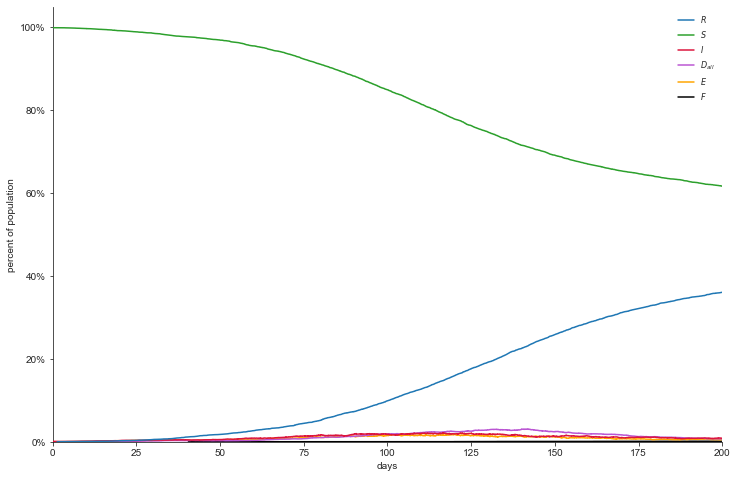

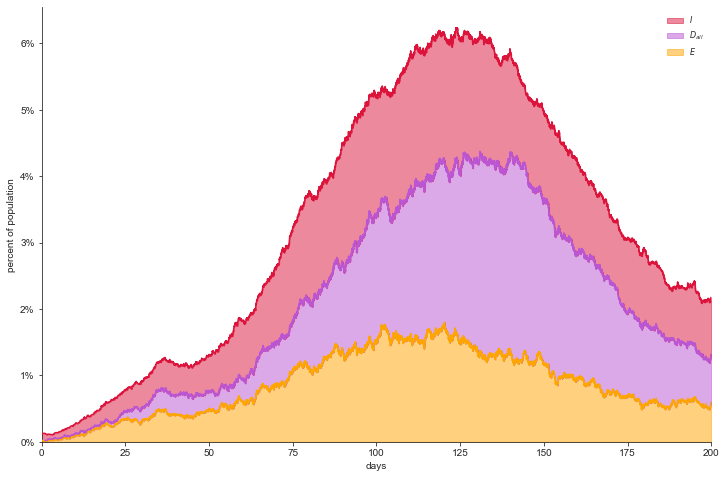

In [52]:
baselineUtah.figure_basic()
plt.show()
baselineUtah.figure_infections()
plt.show()

### Stimulus simulation: incomes below 75k recieve $2000

In [53]:
stimulusUtah = runSimulationStimulus(200, 75000, 2000, state="Utah")

Set up the list!
Set up the edge connections!
Total cost of stimulus: 9507600
t = 0.36
[Checkpoint: Updating parameters]
t = 10.28
[Checkpoint: Updating parameters]
t = 20.19
[Checkpoint: Updating parameters]
t = 30.04
[Checkpoint: Updating parameters]
t = 40.06
[Checkpoint: Updating parameters]
t = 50.00
[Checkpoint: Updating parameters]
t = 60.01
[Checkpoint: Updating parameters]
t = 70.04
[Checkpoint: Updating parameters]
t = 80.01
[Checkpoint: Updating parameters]
t = 90.00
[Checkpoint: Updating parameters]
t = 100.02
[Checkpoint: Updating parameters]
t = 110.01
[Checkpoint: Updating parameters]
t = 120.00
[Checkpoint: Updating parameters]
t = 130.00
[Checkpoint: Updating parameters]
t = 140.00
[Checkpoint: Updating parameters]
t = 150.00
[Checkpoint: Updating parameters]
t = 160.01
[Checkpoint: Updating parameters]
t = 170.01
[Checkpoint: Updating parameters]
t = 180.02
[Checkpoint: Updating parameters]
t = 190.01
[Checkpoint: Updating parameters]
t = 200.01


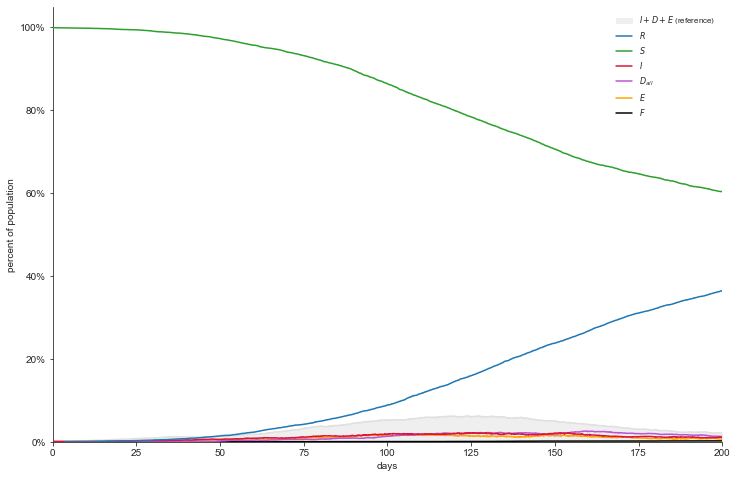

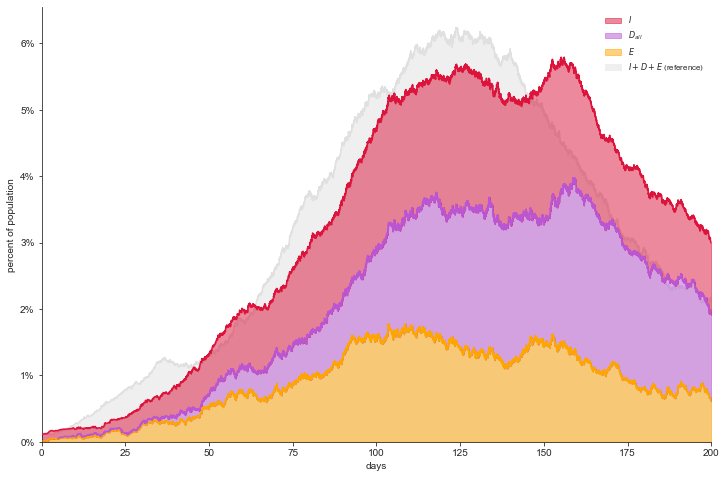

In [54]:
stimulusUtah.figure_basic(shaded_reference_results=baselineUtah)
plt.show()
stimulusUtah.figure_infections(shaded_reference_results=baselineUtah)
plt.show()

### Paycut simulation: ~30% of population gets 10-20% cut in income

In [55]:
paycutUtah = runSimulationPayCut(unit_time=200, payCutProbability=.3, state="Utah")

Set up the list!
Set up the edge connections!
t = 0.06
[Checkpoint: Updating parameters]
t = 10.08
[Checkpoint: Updating parameters]
t = 20.13
[Checkpoint: Updating parameters]
t = 30.28
[Checkpoint: Updating parameters]
t = 40.11
[Checkpoint: Updating parameters]
t = 50.27
[Checkpoint: Updating parameters]
t = 60.00
[Checkpoint: Updating parameters]
t = 70.06
[Checkpoint: Updating parameters]
t = 80.04
[Checkpoint: Updating parameters]
t = 90.01
[Checkpoint: Updating parameters]
t = 100.02
[Checkpoint: Updating parameters]
t = 110.00
[Checkpoint: Updating parameters]
t = 120.00
[Checkpoint: Updating parameters]
t = 130.00
[Checkpoint: Updating parameters]
t = 140.00
[Checkpoint: Updating parameters]
t = 150.05
[Checkpoint: Updating parameters]
t = 160.03
[Checkpoint: Updating parameters]
t = 170.01
[Checkpoint: Updating parameters]
t = 180.02
[Checkpoint: Updating parameters]
t = 190.02
[Checkpoint: Updating parameters]
t = 200.01


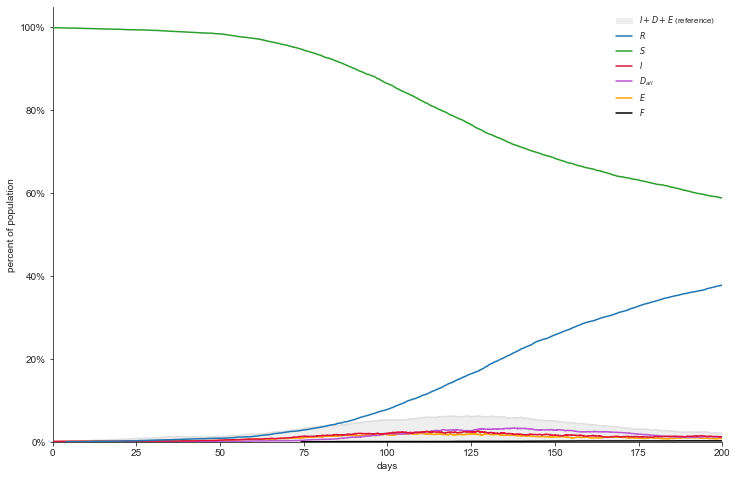

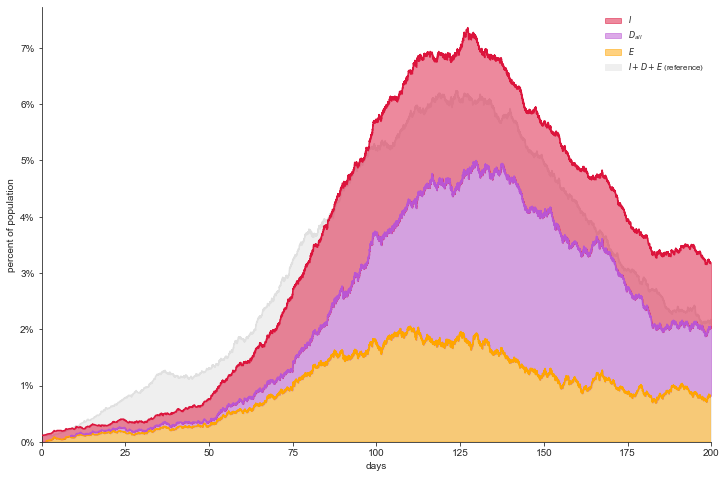

In [56]:
paycutUtah.figure_basic(shaded_reference_results=baselineUtah)
plt.show()
paycutUtah.figure_infections(shaded_reference_results=baselineUtah)
plt.show()

### Layoff simulation: ~10% of population loses job

In [57]:
layoffUtah = runSimulationLaidOff(unit_time=200, laidOffProbability=.1, state="Utah")

Set up the list!
Set up the edge connections!
t = 0.27
[Checkpoint: Updating parameters]
t = 10.25
[Checkpoint: Updating parameters]
t = 20.01
[Checkpoint: Updating parameters]
t = 30.10
[Checkpoint: Updating parameters]
t = 40.29
[Checkpoint: Updating parameters]
t = 50.04
[Checkpoint: Updating parameters]
t = 60.05
[Checkpoint: Updating parameters]
t = 70.10
[Checkpoint: Updating parameters]
t = 80.02
[Checkpoint: Updating parameters]
t = 90.02
[Checkpoint: Updating parameters]
t = 100.02
[Checkpoint: Updating parameters]
t = 110.01
[Checkpoint: Updating parameters]
t = 120.00
[Checkpoint: Updating parameters]
t = 130.00
[Checkpoint: Updating parameters]
t = 140.01
[Checkpoint: Updating parameters]
t = 150.00
[Checkpoint: Updating parameters]
t = 160.02
[Checkpoint: Updating parameters]
t = 170.01
[Checkpoint: Updating parameters]
t = 180.00
[Checkpoint: Updating parameters]
t = 190.01
[Checkpoint: Updating parameters]
t = 200.04


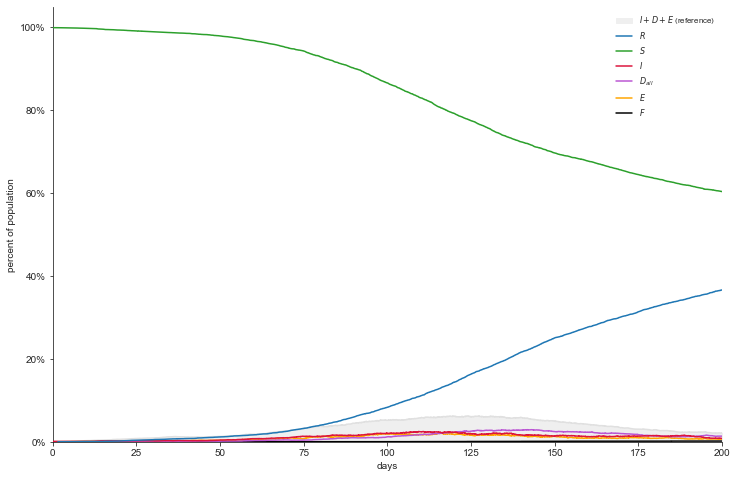

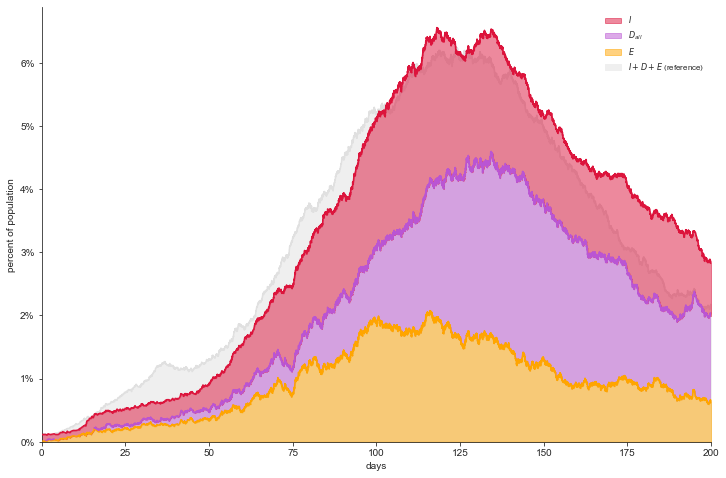

In [58]:
layoffUtah.figure_basic(shaded_reference_results=baselineUtah)
plt.show()
layoffUtah.figure_infections(shaded_reference_results=baselineUtah)
plt.show()

# New Jersey
### Baseline simulation: no income modification

In [60]:
baselineNJ = runSimulationReference(200,"New Jersey")

Set up the list!
Set up the edge connections!
t = 0.75
[Checkpoint: Updating parameters]
t = 10.04
[Checkpoint: Updating parameters]
t = 20.19
[Checkpoint: Updating parameters]
t = 30.02
[Checkpoint: Updating parameters]
t = 40.02
[Checkpoint: Updating parameters]
t = 50.01
[Checkpoint: Updating parameters]
t = 60.00
[Checkpoint: Updating parameters]
t = 70.01
[Checkpoint: Updating parameters]
t = 80.01
[Checkpoint: Updating parameters]
t = 90.00
[Checkpoint: Updating parameters]
t = 100.01
[Checkpoint: Updating parameters]
t = 110.00
[Checkpoint: Updating parameters]
t = 120.01
[Checkpoint: Updating parameters]
t = 130.01
[Checkpoint: Updating parameters]
t = 140.01
[Checkpoint: Updating parameters]
t = 150.00
[Checkpoint: Updating parameters]
t = 160.00
[Checkpoint: Updating parameters]
t = 170.02
[Checkpoint: Updating parameters]
t = 180.03
[Checkpoint: Updating parameters]
t = 190.02
[Checkpoint: Updating parameters]
t = 200.00


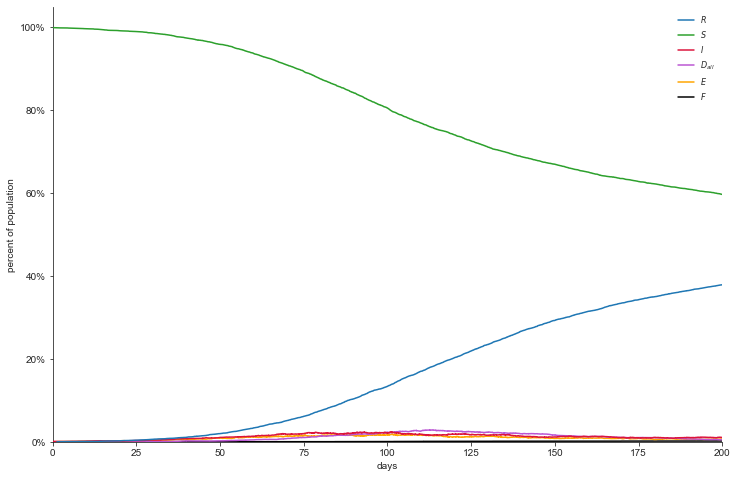

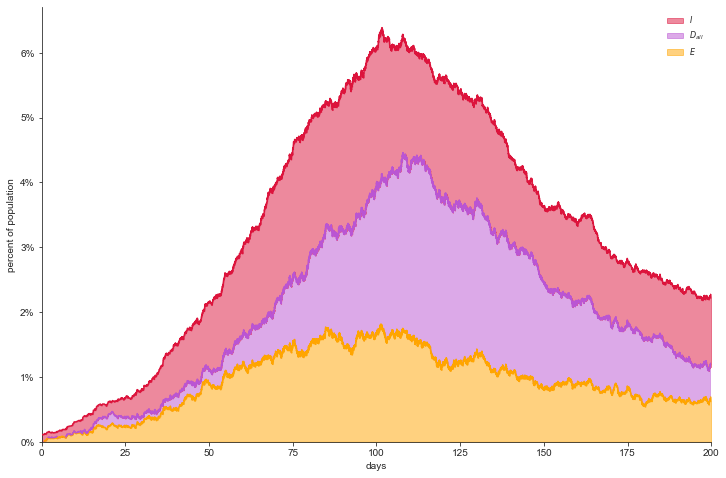

In [61]:
baselineNJ.figure_basic()
plt.show()
baselineNJ.figure_infections()
plt.show()

### Stimulus simulation: incomes below 75k recieve $2000

In [63]:
stimulusNJ = runSimulationStimulus(200, 75000, 2000, state="New Jersey")

Set up the list!
Set up the edge connections!
Total cost of stimulus: 9507600
[Checkpoint: Updating parameters]
t = 10.57
[Checkpoint: Updating parameters]
t = 20.01
[Checkpoint: Updating parameters]
t = 30.01
[Checkpoint: Updating parameters]
t = 40.03
[Checkpoint: Updating parameters]
t = 50.05
[Checkpoint: Updating parameters]
t = 60.04
[Checkpoint: Updating parameters]
t = 70.04
[Checkpoint: Updating parameters]
t = 80.00
[Checkpoint: Updating parameters]
t = 90.01
[Checkpoint: Updating parameters]
t = 100.00
[Checkpoint: Updating parameters]
t = 110.02
[Checkpoint: Updating parameters]
t = 120.00
[Checkpoint: Updating parameters]
t = 130.00
[Checkpoint: Updating parameters]
t = 140.00
[Checkpoint: Updating parameters]
t = 150.00
[Checkpoint: Updating parameters]
t = 160.00
[Checkpoint: Updating parameters]
t = 170.00
[Checkpoint: Updating parameters]
t = 180.00
[Checkpoint: Updating parameters]
t = 190.01
[Checkpoint: Updating parameters]
t = 200.05


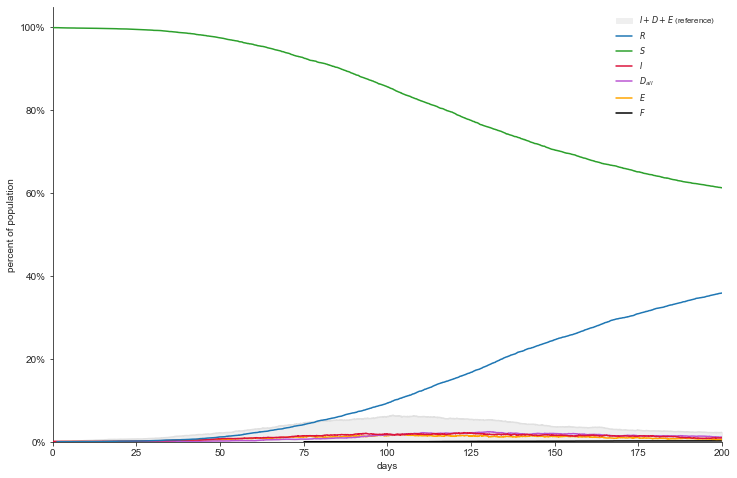

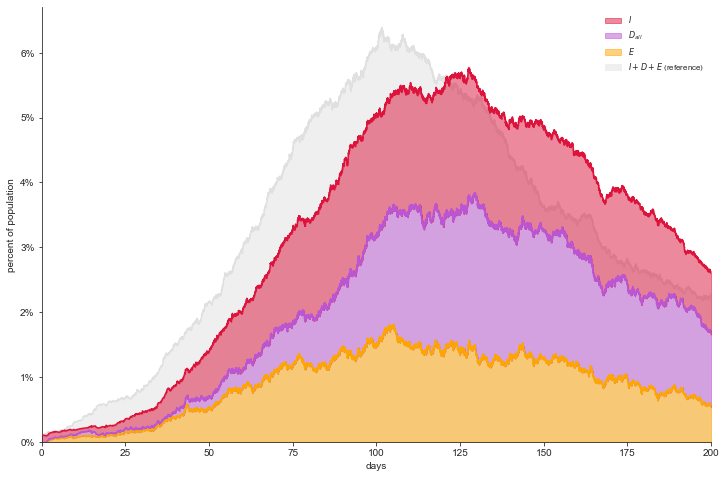

In [64]:
stimulusNJ.figure_basic(shaded_reference_results=baselineNJ)
plt.show()
stimulusNJ.figure_infections(shaded_reference_results=baselineNJ)
plt.show()

### Paycut simulation: ~30% of population gets 10-20% cut in income

In [65]:
paycutNJ = runSimulationPayCut(unit_time=200, payCutProbability=.3, state="New Jersey")

Set up the list!
Set up the edge connections!
t = 0.35
[Checkpoint: Updating parameters]
t = 10.54
[Checkpoint: Updating parameters]
t = 20.78
[Checkpoint: Updating parameters]
t = 30.06
[Checkpoint: Updating parameters]
t = 40.01
[Checkpoint: Updating parameters]
t = 50.02
[Checkpoint: Updating parameters]
t = 60.02
[Checkpoint: Updating parameters]
t = 70.03
[Checkpoint: Updating parameters]
t = 80.01
[Checkpoint: Updating parameters]
t = 90.00
[Checkpoint: Updating parameters]
t = 100.01
[Checkpoint: Updating parameters]
t = 110.00
[Checkpoint: Updating parameters]
t = 120.02
[Checkpoint: Updating parameters]
t = 130.01
[Checkpoint: Updating parameters]
t = 140.02
[Checkpoint: Updating parameters]
t = 150.01
[Checkpoint: Updating parameters]
t = 160.03
[Checkpoint: Updating parameters]
t = 170.01
[Checkpoint: Updating parameters]
t = 180.02
[Checkpoint: Updating parameters]
t = 190.04
[Checkpoint: Updating parameters]
t = 200.05


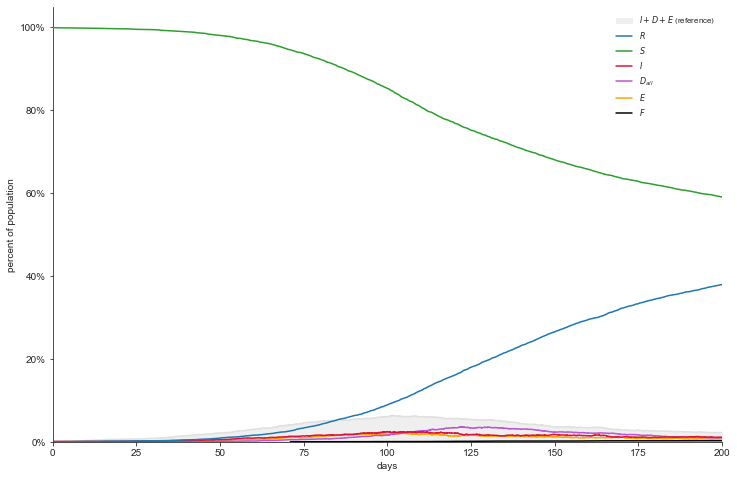

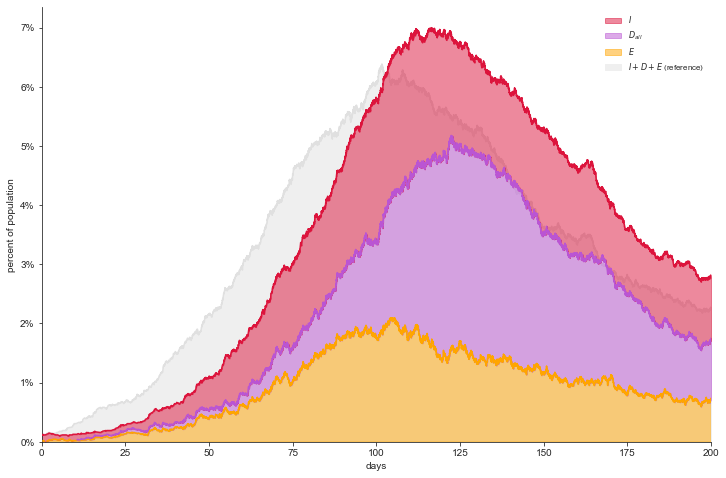

In [66]:
paycutNJ.figure_basic(shaded_reference_results=baselineNJ)
plt.show()
paycutNJ.figure_infections(shaded_reference_results=baselineNJ)
plt.show()

### Layoff simulation: ~10% of population loses job

In [67]:
layoffNJ = runSimulationLaidOff(unit_time=200, laidOffProbability=.1, state="New Jersey")

Set up the list!
Set up the edge connections!
t = 0.13
[Checkpoint: Updating parameters]
t = 10.01
[Checkpoint: Updating parameters]
t = 20.10
[Checkpoint: Updating parameters]
t = 30.06
[Checkpoint: Updating parameters]
t = 40.04
[Checkpoint: Updating parameters]
t = 50.00
[Checkpoint: Updating parameters]
t = 60.00
[Checkpoint: Updating parameters]
t = 70.03
[Checkpoint: Updating parameters]
t = 80.01
[Checkpoint: Updating parameters]
t = 90.01
[Checkpoint: Updating parameters]
t = 100.01
[Checkpoint: Updating parameters]
t = 110.00
[Checkpoint: Updating parameters]
t = 120.02
[Checkpoint: Updating parameters]
t = 130.00
[Checkpoint: Updating parameters]
t = 140.02
[Checkpoint: Updating parameters]
t = 150.03
[Checkpoint: Updating parameters]
t = 160.01
[Checkpoint: Updating parameters]
t = 170.01
[Checkpoint: Updating parameters]
t = 180.03
[Checkpoint: Updating parameters]
t = 190.02
[Checkpoint: Updating parameters]
t = 200.01


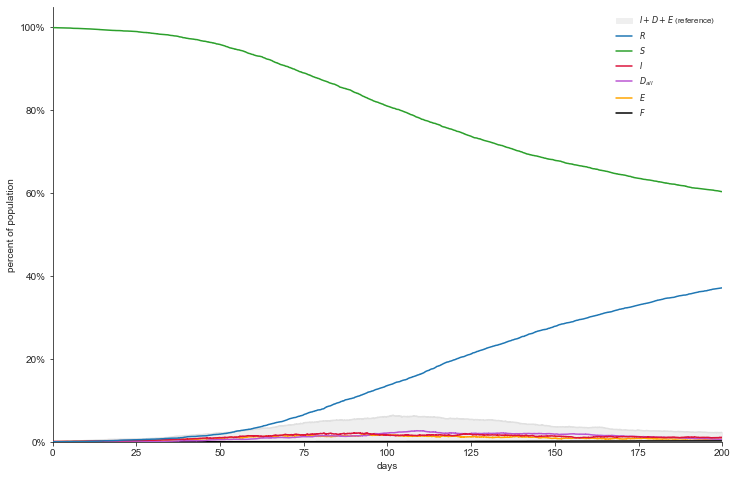

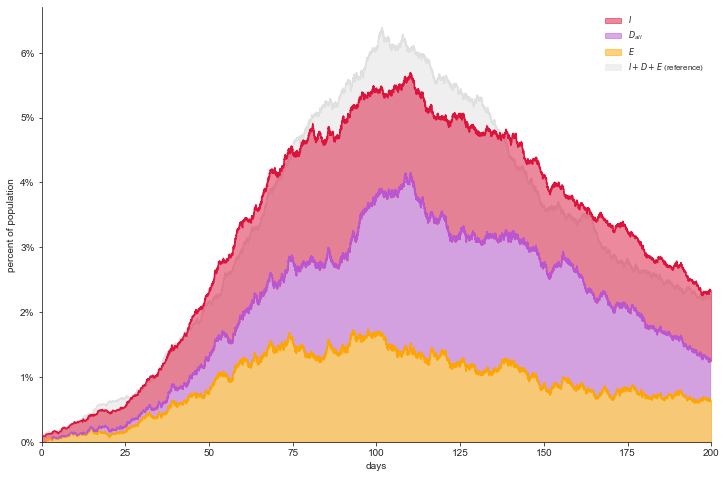

In [68]:
layoffNJ.figure_basic(shaded_reference_results=baselineNJ)
plt.show()
layoffNJ.figure_infections(shaded_reference_results=baselineNJ)
plt.show()

# Georgia
### Baseline simulation: no income modification

In [69]:
baselineGA = runSimulationReference(200,"Georgia")

Set up the list!
Set up the edge connections!
[Checkpoint: Updating parameters]
t = 10.15
[Checkpoint: Updating parameters]
t = 20.37
[Checkpoint: Updating parameters]
t = 30.00
[Checkpoint: Updating parameters]
t = 40.24
[Checkpoint: Updating parameters]
t = 50.00
[Checkpoint: Updating parameters]
t = 60.09
[Checkpoint: Updating parameters]
t = 70.01
[Checkpoint: Updating parameters]
t = 80.03
[Checkpoint: Updating parameters]
t = 90.02
[Checkpoint: Updating parameters]
t = 100.02
[Checkpoint: Updating parameters]
t = 110.00
[Checkpoint: Updating parameters]
t = 120.00
[Checkpoint: Updating parameters]
t = 130.02
[Checkpoint: Updating parameters]
t = 140.00
[Checkpoint: Updating parameters]
t = 150.05
[Checkpoint: Updating parameters]
t = 160.01
[Checkpoint: Updating parameters]
t = 170.03
[Checkpoint: Updating parameters]
t = 180.00
[Checkpoint: Updating parameters]
t = 190.02
[Checkpoint: Updating parameters]
t = 200.01


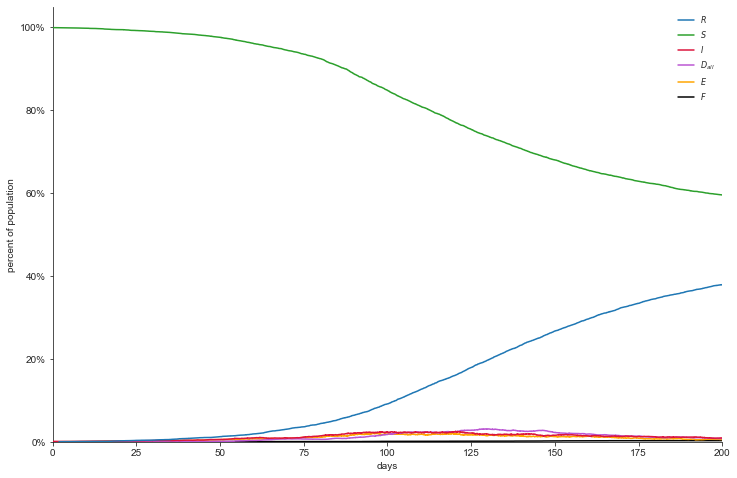

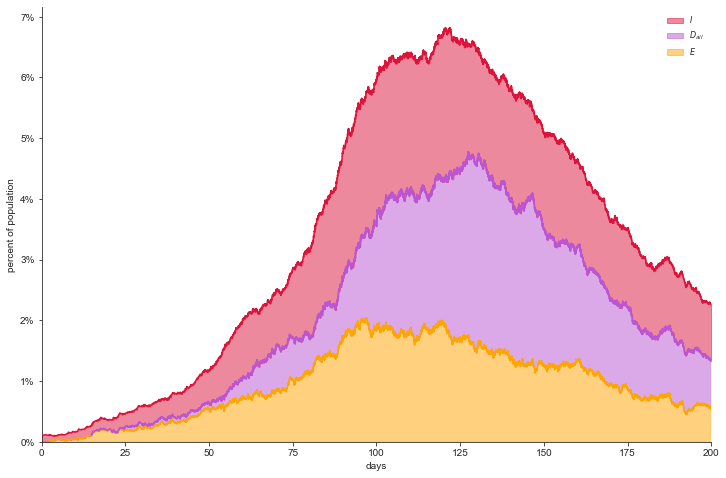

In [70]:
baselineGA.figure_basic()
plt.show()
baselineGA.figure_infections()
plt.show()

### Stimulus simulation: incomes below 75k recieve $2000

In [71]:
stimulusGA = runSimulationStimulus(200, 75000, 2000, state="Georgia")

Set up the list!
Set up the edge connections!
Total cost of stimulus: 9507600
t = 0.77
[Checkpoint: Updating parameters]
t = 10.11
[Checkpoint: Updating parameters]
t = 20.37
[Checkpoint: Updating parameters]
t = 30.18
[Checkpoint: Updating parameters]
t = 40.05
[Checkpoint: Updating parameters]
t = 50.04
[Checkpoint: Updating parameters]
t = 60.00
[Checkpoint: Updating parameters]
t = 70.01
[Checkpoint: Updating parameters]
t = 80.03
[Checkpoint: Updating parameters]
t = 90.01
[Checkpoint: Updating parameters]
t = 100.01
[Checkpoint: Updating parameters]
t = 110.02
[Checkpoint: Updating parameters]
t = 120.00
[Checkpoint: Updating parameters]
t = 130.00
[Checkpoint: Updating parameters]
t = 140.01
[Checkpoint: Updating parameters]
t = 150.01
[Checkpoint: Updating parameters]
t = 160.00
[Checkpoint: Updating parameters]
t = 170.02
[Checkpoint: Updating parameters]
t = 180.01
[Checkpoint: Updating parameters]
t = 190.03
[Checkpoint: Updating parameters]
t = 200.03


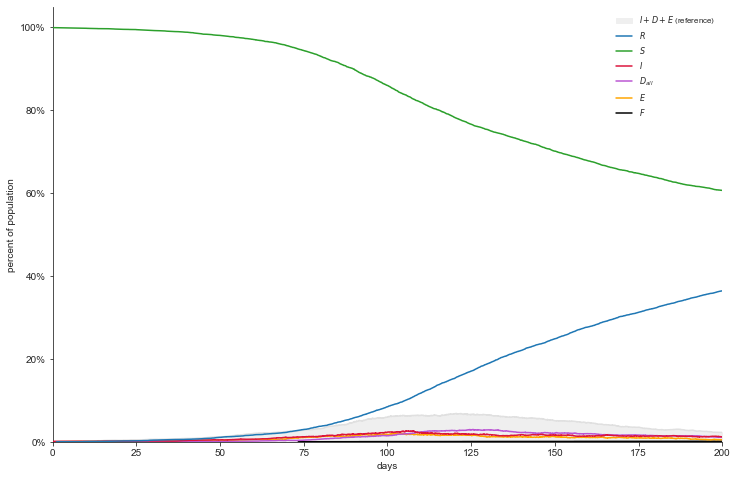

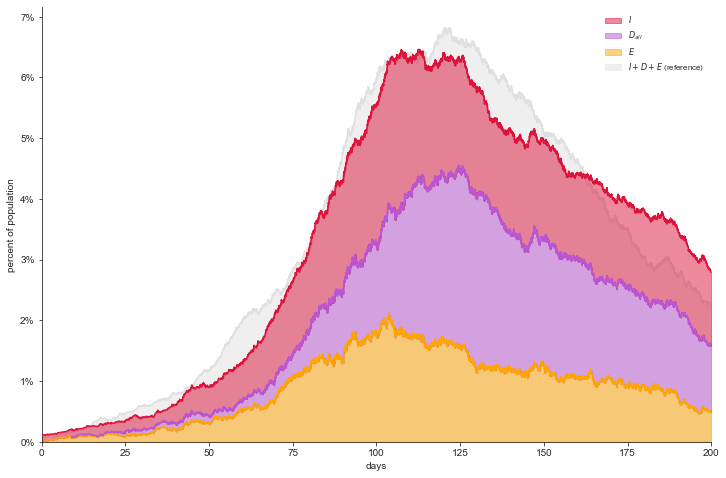

In [72]:
stimulusGA.figure_basic(shaded_reference_results=baselineGA)
plt.show()
stimulusGA.figure_infections(shaded_reference_results=baselineGA)
plt.show()

### Paycut simulation: ~30% of population gets 10-20% cut in income

In [73]:
paycutGA = runSimulationPayCut(unit_time=200, payCutProbability=.3, state="Georgia")

Set up the list!
Set up the edge connections!
t = 0.30
[Checkpoint: Updating parameters]
t = 10.63
[Checkpoint: Updating parameters]
t = 20.15
[Checkpoint: Updating parameters]
t = 30.01
[Checkpoint: Updating parameters]
t = 40.03
[Checkpoint: Updating parameters]
t = 50.02
[Checkpoint: Updating parameters]
t = 60.03
[Checkpoint: Updating parameters]
t = 70.01
[Checkpoint: Updating parameters]
t = 80.00
[Checkpoint: Updating parameters]
t = 90.00
[Checkpoint: Updating parameters]
t = 100.03
[Checkpoint: Updating parameters]
t = 110.01
[Checkpoint: Updating parameters]
t = 120.00
[Checkpoint: Updating parameters]
t = 130.02
[Checkpoint: Updating parameters]
t = 140.00
[Checkpoint: Updating parameters]
t = 150.01
[Checkpoint: Updating parameters]
t = 160.01
[Checkpoint: Updating parameters]
t = 170.00
[Checkpoint: Updating parameters]
t = 180.01
[Checkpoint: Updating parameters]
t = 190.03
[Checkpoint: Updating parameters]
t = 200.06


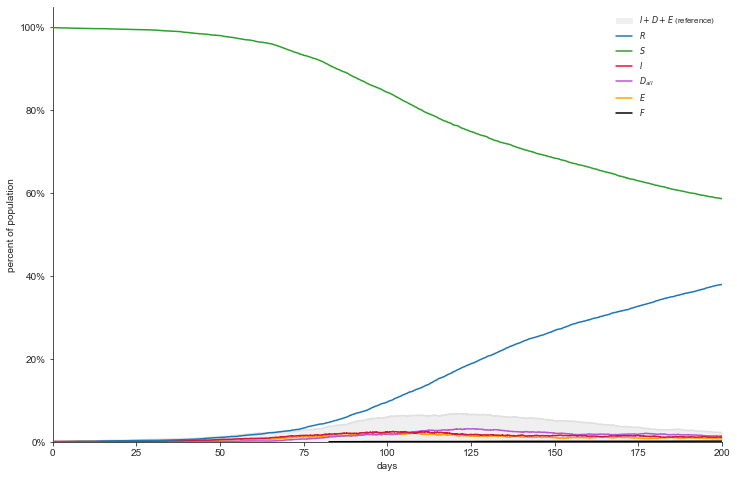

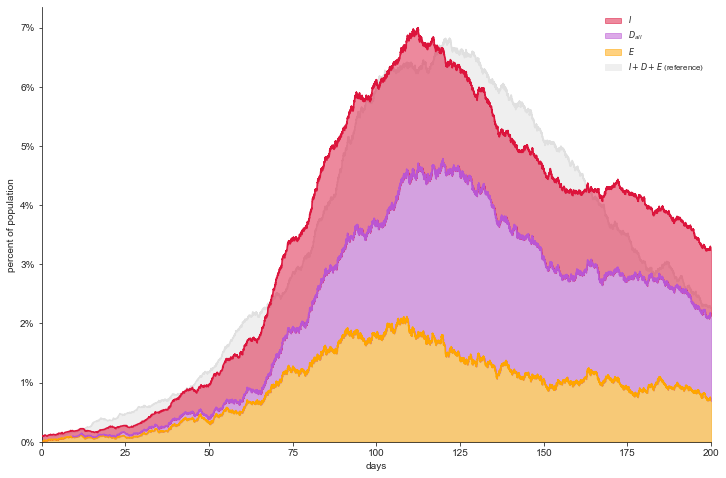

In [74]:
paycutGA.figure_basic(shaded_reference_results=baselineGA)
plt.show()
paycutGA.figure_infections(shaded_reference_results=baselineGA)
plt.show()

### Layoff simulation: ~10% of population loses job

In [75]:
layoffGA = runSimulationLaidOff(unit_time=200, laidOffProbability=.1, state="Georgia")

Set up the list!
Set up the edge connections!
t = 0.53
[Checkpoint: Updating parameters]
t = 10.23
[Checkpoint: Updating parameters]
t = 20.04
[Checkpoint: Updating parameters]
t = 30.03
[Checkpoint: Updating parameters]
t = 40.06
[Checkpoint: Updating parameters]
t = 50.01
[Checkpoint: Updating parameters]
t = 60.04
[Checkpoint: Updating parameters]
t = 70.00
[Checkpoint: Updating parameters]
t = 80.00
[Checkpoint: Updating parameters]
t = 90.00
[Checkpoint: Updating parameters]
t = 100.00
[Checkpoint: Updating parameters]
t = 110.00
[Checkpoint: Updating parameters]
t = 120.02
[Checkpoint: Updating parameters]
t = 130.00
[Checkpoint: Updating parameters]
t = 140.01
[Checkpoint: Updating parameters]
t = 150.00
[Checkpoint: Updating parameters]
t = 160.06
[Checkpoint: Updating parameters]
t = 170.00
[Checkpoint: Updating parameters]
t = 180.06
[Checkpoint: Updating parameters]
t = 190.03
[Checkpoint: Updating parameters]
t = 200.05


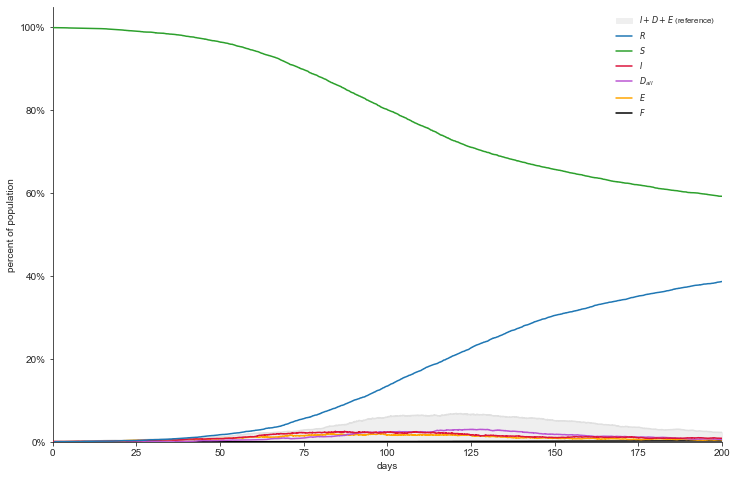

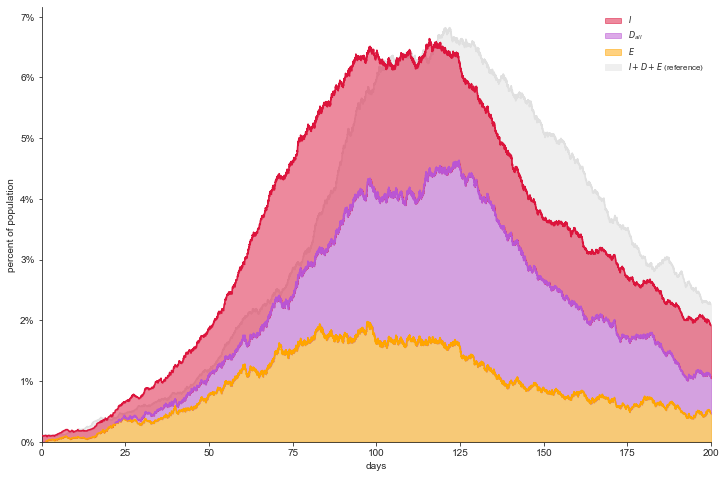

In [76]:
layoffGA.figure_basic(shaded_reference_results=baselineGA)
plt.show()
layoffGA.figure_infections(shaded_reference_results=baselineGA)
plt.show()

# Washington
### Baseline simulation: no income modification

In [77]:
baselineWA = runSimulationReference(200,"Washington")

Set up the list!
Set up the edge connections!
t = 0.08
[Checkpoint: Updating parameters]
t = 10.02
[Checkpoint: Updating parameters]
t = 20.24
[Checkpoint: Updating parameters]
t = 30.01
[Checkpoint: Updating parameters]
t = 40.03
[Checkpoint: Updating parameters]
t = 50.01
[Checkpoint: Updating parameters]
t = 60.01
[Checkpoint: Updating parameters]
t = 70.01
[Checkpoint: Updating parameters]
t = 80.00
[Checkpoint: Updating parameters]
t = 90.00
[Checkpoint: Updating parameters]
t = 100.01
[Checkpoint: Updating parameters]
t = 110.02
[Checkpoint: Updating parameters]
t = 120.00
[Checkpoint: Updating parameters]
t = 130.01
[Checkpoint: Updating parameters]
t = 140.02
[Checkpoint: Updating parameters]
t = 150.03
[Checkpoint: Updating parameters]
t = 160.01
[Checkpoint: Updating parameters]
t = 170.01
[Checkpoint: Updating parameters]
t = 180.03
[Checkpoint: Updating parameters]
t = 190.02
[Checkpoint: Updating parameters]
t = 200.01


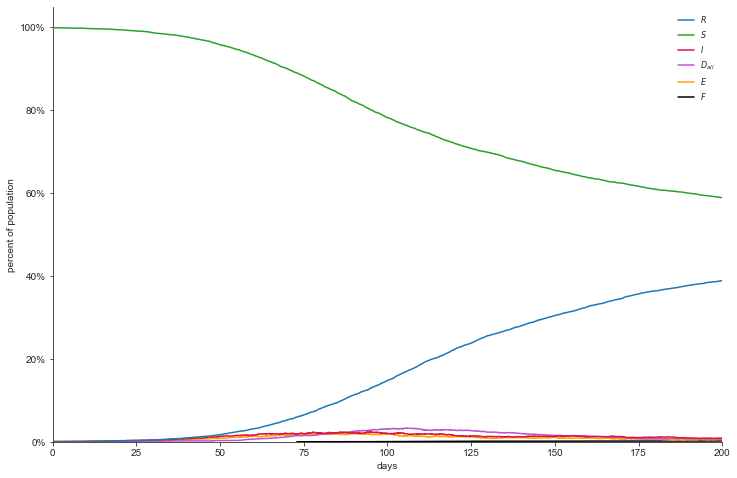

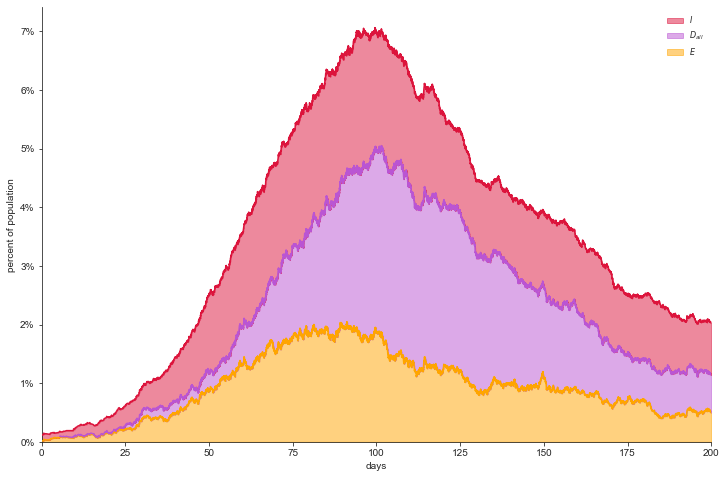

In [78]:
baselineWA.figure_basic()
plt.show()
baselineWA.figure_infections()
plt.show()

### Stimulus simulation: incomes below 75k recieve $2000

In [81]:
stimulusWA = runSimulationStimulus(200, 75000, 2000, state="Washington")

Set up the list!
Set up the edge connections!
Total cost of stimulus: 9507600
t = 0.01
[Checkpoint: Updating parameters]
t = 10.57
[Checkpoint: Updating parameters]
t = 20.13
[Checkpoint: Updating parameters]
t = 30.08
[Checkpoint: Updating parameters]
t = 40.01
[Checkpoint: Updating parameters]
t = 50.03
[Checkpoint: Updating parameters]
t = 60.00
[Checkpoint: Updating parameters]
t = 70.00
[Checkpoint: Updating parameters]
t = 80.00
[Checkpoint: Updating parameters]
t = 90.03
[Checkpoint: Updating parameters]
t = 100.01
[Checkpoint: Updating parameters]
t = 110.00
[Checkpoint: Updating parameters]
t = 120.00
[Checkpoint: Updating parameters]
t = 130.01
[Checkpoint: Updating parameters]
t = 140.02
[Checkpoint: Updating parameters]
t = 150.01
[Checkpoint: Updating parameters]
t = 160.01
[Checkpoint: Updating parameters]
t = 170.00
[Checkpoint: Updating parameters]
t = 180.03
[Checkpoint: Updating parameters]
t = 190.00
[Checkpoint: Updating parameters]
t = 200.01


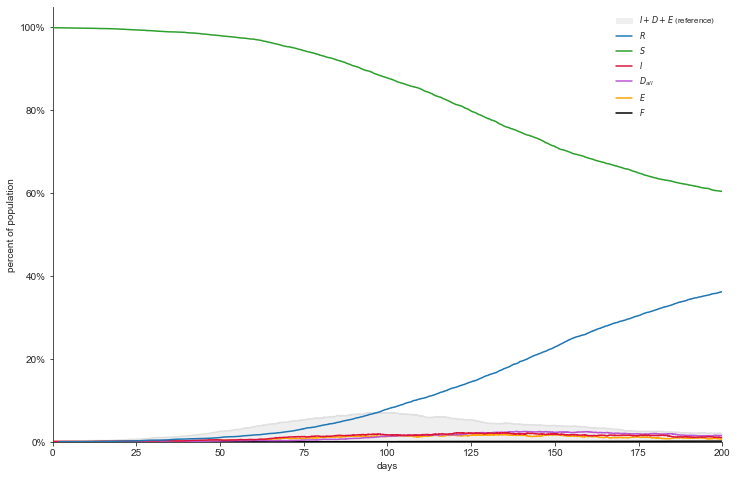

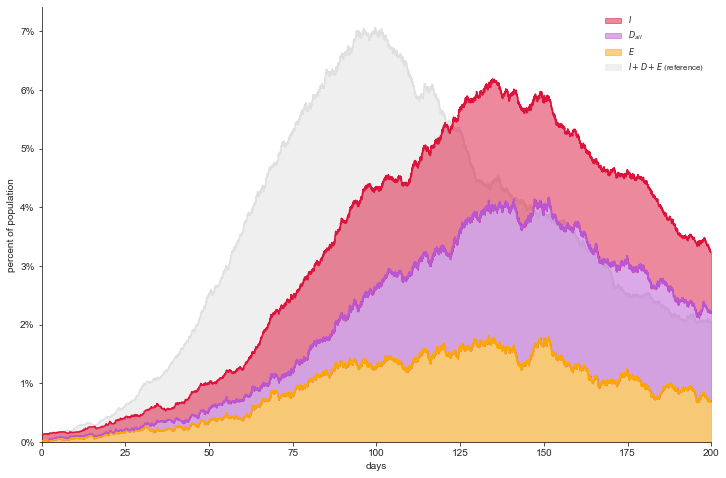

In [82]:
stimulusWA.figure_basic(shaded_reference_results=baselineWA)
plt.show()
stimulusWA.figure_infections(shaded_reference_results=baselineWA)
plt.show()

### Paycut simulation: ~30% of population gets 10-20% cut in income

In [85]:
paycutWA = runSimulationPayCut(unit_time=200, payCutProbability=.3, state="Washington")

Set up the list!
Set up the edge connections!
t = 0.20
[Checkpoint: Updating parameters]
t = 10.13
[Checkpoint: Updating parameters]
t = 20.01
[Checkpoint: Updating parameters]
t = 30.06
[Checkpoint: Updating parameters]
t = 40.01
[Checkpoint: Updating parameters]
t = 50.03
[Checkpoint: Updating parameters]
t = 60.01
[Checkpoint: Updating parameters]
t = 70.01
[Checkpoint: Updating parameters]
t = 80.01
[Checkpoint: Updating parameters]
t = 90.00
[Checkpoint: Updating parameters]
t = 100.00
[Checkpoint: Updating parameters]
t = 110.01
[Checkpoint: Updating parameters]
t = 120.00
[Checkpoint: Updating parameters]
t = 130.03
[Checkpoint: Updating parameters]
t = 140.00
[Checkpoint: Updating parameters]
t = 150.03
[Checkpoint: Updating parameters]
t = 160.01
[Checkpoint: Updating parameters]
t = 170.01
[Checkpoint: Updating parameters]
t = 180.01
[Checkpoint: Updating parameters]
t = 190.00
[Checkpoint: Updating parameters]
t = 200.00


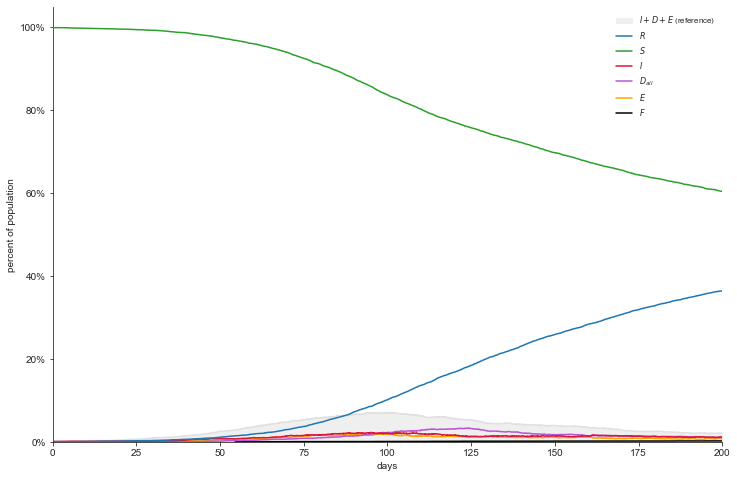

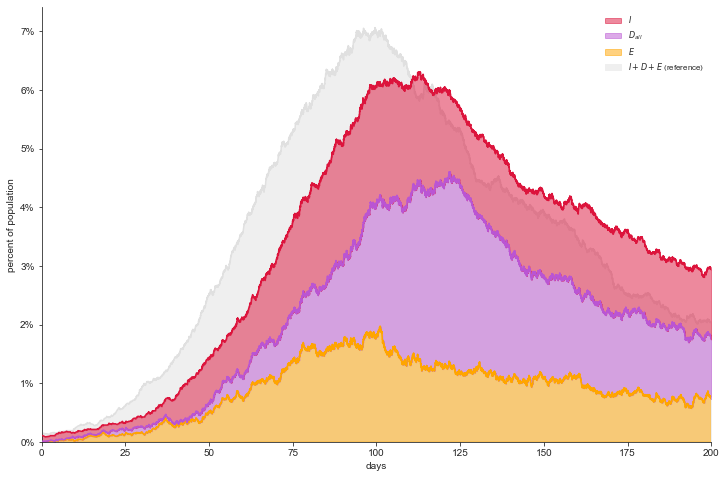

In [86]:
paycutWA.figure_basic(shaded_reference_results=baselineWA)
plt.show()
paycutWA.figure_infections(shaded_reference_results=baselineWA)
plt.show()

### Layoff simulation: ~10% of population loses job

In [89]:
layoffWA =runSimulationLaidOff(unit_time=200, laidOffProbability=.1, state="Washington")

Set up the list!
Set up the edge connections!
t = 0.01
[Checkpoint: Updating parameters]
t = 10.20
[Checkpoint: Updating parameters]
t = 20.19
[Checkpoint: Updating parameters]
t = 30.24
[Checkpoint: Updating parameters]
t = 40.03
[Checkpoint: Updating parameters]
t = 50.05
[Checkpoint: Updating parameters]
t = 60.04
[Checkpoint: Updating parameters]
t = 70.03
[Checkpoint: Updating parameters]
t = 80.00
[Checkpoint: Updating parameters]
t = 90.01
[Checkpoint: Updating parameters]
t = 100.01
[Checkpoint: Updating parameters]
t = 110.00
[Checkpoint: Updating parameters]
t = 120.00
[Checkpoint: Updating parameters]
t = 130.00
[Checkpoint: Updating parameters]
t = 140.02
[Checkpoint: Updating parameters]
t = 150.02
[Checkpoint: Updating parameters]
t = 160.02
[Checkpoint: Updating parameters]
t = 170.02
[Checkpoint: Updating parameters]
t = 180.00
[Checkpoint: Updating parameters]
t = 190.01
[Checkpoint: Updating parameters]
t = 200.10


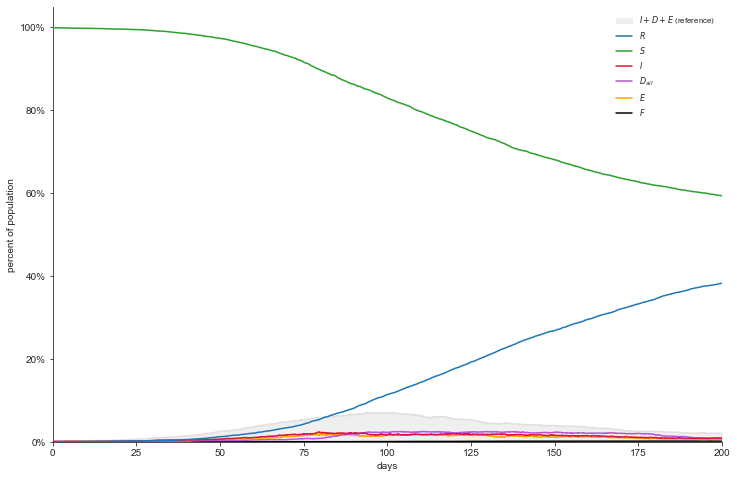

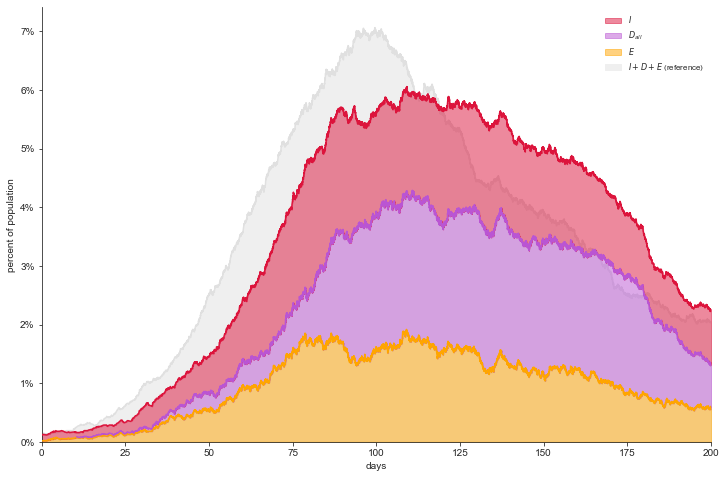

In [90]:
layoffWA.figure_basic(shaded_reference_results=baselineWA)
plt.show()
layoffWA.figure_infections(shaded_reference_results=baselineWA)
plt.show()